# BPE Tokenization vs Character Level tokenizations on LSTMs using Tiny Shakespeare

In this notebook I will be using Byte Pair Encoding subword tokenization on my previously built LSTM to see the difference it makes for the learning and next token prediction

In [1]:
import torch
import requests
import os
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader, Subset
from collections import Counter
import random
import time
import re

In [2]:
# Directories
cwd = os.getcwd()
data_dir = os.path.join(cwd, "/data/")
artifacts_dir = os.path.join(cwd, "/artifacts/")
model_prefix = os.path.join(artifacts_dir, "shakespear_bpe")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

if response.status_code == 200:
    text = response.text
    print(f"Length of text: {len(text)}")
    print("First 500 Chars")
    print("\n" + "=" * 50 + "\n")

    corpus_path = os.path.join(data_dir, "corpus.txt")
    with open(corpus_path, 'w', encoding='utf-8') as f:
        f.write(text)

    print(f"Successfully saved corpus to: {corpus_path}")
    print(f"File size: {os.path.getsize(corpus_path)} bytes")

else:
    print(f"Failed to download text. Status code: {response.status_code}")


Length of text: 1115394
First 500 Chars


Successfully saved corpus to: /data/corpus.txt
File size: 1115394 bytes


# Byte Pair Encoding vocab and tokenizer building

In [4]:
def train_sentencepiece(corpus_path, model_prefix, vocab_size=8000):
    """
    Train a SentencePiece BPE tokenizer optimized for low <unk> on Shakespeare.
    """
    if not os.path.exists(corpus_path):
        print(f"Error: Corpus file not found at {corpus_path}")
        return None, None

    corpus_size = os.path.getsize(corpus_path)
    print(f"Corpus Loaded: {corpus_path}")
    print(f"Corpus Size: {corpus_size:,} bytes ({corpus_size / 1e6:.1f} MB)")

    print(f"Training BPE tokenizer with vocab size: {vocab_size} (optimized for low <unk>)")
    print("="*60)

    training_args = {
        'input': corpus_path,
        'model_prefix': model_prefix,
        'vocab_size': vocab_size,
        'model_type': 'bpe',


        'character_coverage': 1.0,  # Full coverage (no skipping rare chars)
        'input_sentence_size': -1,  # Use entire corpus (no limit)
        'shuffle_input_sentence': True,  # Better sampling
        'max_sentence_length': 8192,  # Allow longer lines (Shakespeare has long speeches)

        # Token layout
        'pad_id': 0,
        'unk_id': 1,
        'bos_id': -1,
        'eos_id': -1,

        # Processing (tuned for English literature)
        'num_threads': 4,
        'byte_fallback': False,  # Force subwords over bytes (reduces <unk>)
        'split_by_unicode_script': True,
        'split_by_number': False,  # Keep numbers intact (rare in Shakespeare)
        'split_digits': False,  # Don't split digits (avoids <unk> fragments)

        # Better merge quality
        'hard_vocab_limit': False,  # Allow vocab to exceed if needed
    }

    try:
        print("Starting Training... (this may take 1-2 min with larger vocab)")
        spm.SentencePieceTrainer.train(**training_args)
        print("Training Completed!")

        model_file = f"{model_prefix}.model"
        vocab_file = f"{model_prefix}.vocab"

        if os.path.exists(model_file) and os.path.exists(vocab_file):
            actual_vocab_size = sum(1 for _ in open(vocab_file, 'r'))

            print(f"\n✅ Success!")
            print(f"Model file: {model_file} ({os.path.getsize(model_file):,} bytes)")
            print(f"Vocab file: {vocab_file} ({os.path.getsize(vocab_file):,} bytes)")
            print(f"Vocab size: {actual_vocab_size} tokens")

            print(f"\nFirst 20 tokens from vocabulary:")
            print("-"*40)

            with open(vocab_file, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if i >= 20:
                        break
                    token, score = line.strip().split('\t')
                    display_token = token.replace('▁', '▁')  # Make ▁ visible
                    print(f" {i:2d}: '{display_token}' (score: {float(score):.2f})")

            # Check <unk> count after tokenization
            sp_test = spm.SentencePieceProcessor()
            sp_test.load(model_file)
            test_tokens = sp_test.encode_as_ids(text)  # Tokenize full corpus
            unk_count = sum(1 for t in test_tokens if t == 1)
            unk_ratio = unk_count / len(test_tokens) * 100
            print(f"\n<unk> Analysis (ID=1): {unk_count:,} occurrences ({unk_ratio:.2f}% of corpus)")
            if unk_ratio < 0.1:
                print("✅ Excellent! <unk> is minimal.")
            elif unk_ratio < 1.0:
                print("Acceptable, but consider even larger vocab.")
            else:
                print("Still high – try vocab_size=16000.")

            return model_file, vocab_file
        else:
            print("Training failed - output files not created")
            return None, None
    except Exception as e:
        print(f"Training error: {e}")
        return None, None

# Retrain with better params
vocab_size = 8000  # try 16000 if <unk> still >0.1%
model_file, vocab_file = train_sentencepiece(corpus_path, model_prefix, vocab_size)

Corpus Loaded: /data/corpus.txt
Corpus Size: 1,115,394 bytes (1.1 MB)
Training BPE tokenizer with vocab size: 8000 (optimized for low <unk>)
Starting Training... (this may take 1-2 min with larger vocab)
Training Completed!

✅ Success!
Model file: /artifacts/shakespear_bpe.model (368,008 bytes)
Vocab file: /artifacts/shakespear_bpe.vocab (110,738 bytes)
Vocab size: 8000 tokens

First 20 tokens from vocabulary:
----------------------------------------
  0: '<pad>' (score: 0.00)
  1: '<unk>' (score: 0.00)
  2: '▁t' (score: -0.00)
  3: 'he' (score: -1.00)
  4: '▁a' (score: -2.00)
  5: 'ou' (score: -3.00)
  6: '▁s' (score: -4.00)
  7: '▁m' (score: -5.00)
  8: '▁w' (score: -6.00)
  9: 'in' (score: -7.00)
 10: 're' (score: -8.00)
 11: 'ha' (score: -9.00)
 12: '▁the' (score: -10.00)
 13: 'nd' (score: -11.00)
 14: '▁b' (score: -12.00)
 15: 'is' (score: -13.00)
 16: 'or' (score: -14.00)
 17: '▁f' (score: -15.00)
 18: '▁I' (score: -16.00)
 19: 'er' (score: -17.00)

<unk> Analysis (ID=1): 0 occur

In [6]:
# Testing Tokenizer
sp= spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test sentences
test_sentences= [
    "To be or not to be",
    "All the world's a stage",
    "Wherefore art thou Romeo?",
    "Out, out, brief candle!"
]

for sentence in test_sentences:
    tokens= sp.encode_as_pieces(sentence)
    tokens_ids= sp.encode_as_ids(sentence)

    print(f"Original: {sentence}")
    print(f"Tokens: ({len(tokens)}): {tokens}")
    print(f"IDs : {tokens_ids}")

    avg_tokens_per_word= len(tokens) / len(sentence.split())
    print(f" Avg tokens/word: {avg_tokens_per_word:.1f}")

Original: To be or not to be
Tokens: (6): ['▁To', '▁be', '▁or', '▁not', '▁to', '▁be']
IDs : [161, 52, 279, 71, 34, 52]
 Avg tokens/word: 1.0
Original: All the world's a stage
Tokens: (8): ['▁All', '▁the', '▁world', "'", 's', '▁a', '▁st', 'age']
IDs : [943, 12, 623, 7965, 7942, 4, 97, 463]
 Avg tokens/word: 1.6
Original: Wherefore art thou Romeo?
Tokens: (5): ['▁Wherefore', '▁art', '▁thou', '▁Romeo', '?']
IDs : [5456, 488, 96, 752, 7979]
 Avg tokens/word: 1.2
Original: Out, out, brief candle!
Tokens: (8): ['▁Out', ',', '▁out', ',', '▁brief', '▁c', 'andle', '!']
IDs : [2530, 7951, 365, 7951, 2137, 24, 6903, 7981]
 Avg tokens/word: 2.0


In [7]:
model_file = f"{model_prefix}.model"
vocab_file = f"{model_prefix}.vocab"

print(f"Model file exists: {os.path.exists(model_file)} at {model_file}")
print(f"Vocab file exists: {os.path.exists(vocab_file)} at {vocab_file}")
if os.path.exists(model_file):
    print(f"Model size: {os.path.getsize(model_file):,} bytes")
if os.path.exists(vocab_file):
    print(f"Vocab size: {os.path.getsize(vocab_file):,} bytes")
    print("First 5 lines of vocab:")
    with open(vocab_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(f"  {line.strip()}")

Model file exists: True at /artifacts/shakespear_bpe.model
Vocab file exists: True at /artifacts/shakespear_bpe.vocab
Model size: 368,008 bytes
Vocab size: 110,738 bytes
First 5 lines of vocab:
  <pad>	0
  <unk>	0
  ▁t	-0
  he	-1
  ▁a	-2


In [8]:
class ShakespeareDataset(Dataset):

    def __init__(
            self,
            corpus_path,
            tokenizer_model_path,
            sequence_length=256,
            stride=512,
            vocab_cache_path=None
    ):
        super().__init__()

        self.corpus_path = corpus_path
        self.tokenizer_model_path = tokenizer_model_path
        self.sequence_length = sequence_length
        self.stride = stride

        # Load Tokenizer
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(tokenizer_model_path)
        self.vocab_size = len(self.tokenizer)

        # Load text
        self.raw_text = self._load_corpus()

        # Tokenize the entire corpus
        self.tokens = self._tokenize_corpus()

        # Create sequences for training
        self.sequences = self._create_sequences()

        # Show sample of tokenization
        self._show_tokenization_sample()

    def _load_corpus(self):
        with open(self.corpus_path, 'r', encoding='utf-8') as f:
            return f.read()

    def _tokenize_corpus(self):
        token_ids = self.tokenizer.encode_as_ids(self.raw_text)
        token_counts = Counter(token_ids)

        print("Most frequent tokens:")
        print("-" * 40)
        for token_id, count in token_counts.most_common(15):
            token = self.tokenizer.id_to_piece(token_id)
            print(f"  '{token}' (ID: {token_id}): {count:,} occurrences")

        return token_ids

    def _create_sequences(self):
        sequences = []
        start = 0

        while start + self.sequence_length <= len(self.tokens):
            sequence = self.tokens[start : start + self.sequence_length]
            sequences.append(sequence)
            start += self.stride

        return sequences

    def _show_tokenization_sample(self):
        print(f"Tokenization Sample (sequence length: {self.sequence_length}): ")
        sample_text = "All the world's a stage, and all the"
        sample_tokens = self.tokenizer.encode_as_pieces(sample_text)
        sample_ids = self.tokenizer.encode_as_ids(sample_text)
        print("Raw text:")
        print(f"'{sample_text}'")

        print("Tokenized: ")
        print(f"{sample_tokens}")

        print("Token IDs (What the LSTM sees): ")
        print(f"{sample_ids}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        # For Language Modeling: input = sequence[:-1], target = sequence[1:]
        input_seq = torch.tensor(sequence[:-1], dtype=torch.long)
        target_seq = torch.tensor(sequence[1:], dtype=torch.long)

        return input_seq, target_seq

    def get_tokenizer(self):
        return self.tokenizer



In [9]:
def create_dataloaders(
        dataset,
        batch_size=32,
        train_split=0.8,
        val_split=0.2,
        shuffle=True
):
    total_length = len(dataset)
    train_size = int(total_length * train_split)
    val_size = int(total_length * val_split)
    test_size = total_length - train_size - val_size  # Add test split

    indices = list(range(total_length))

    if shuffle:
        random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    def collate_fn(batch):
        inputs = torch.stack([item[0] for item in batch])
        targets = torch.stack([item[1] for item in batch])
        return inputs, targets

    train_loader = DataLoader(
        Subset(dataset, train_indices),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        Subset(dataset, val_indices),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        Subset(dataset, test_indices),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    return train_loader, val_loader, test_loader


In [10]:
def visualize_data(dataloader: DataLoader, dataset: ShakespeareDataset, num_examples: int = 3):
    tokenizer = dataset.get_tokenizer()

    print(f"\n Data Pipeline Verification ({num_examples} examples):")
    print("="*70)

    batch = next(iter(dataloader))
    inputs, targets = batch

    print(f"   Batch shape:")
    print(f"   Input sequences: {inputs.shape} (batch_size, seq_len-1)")
    print(f"   Target sequences: {targets.shape} (batch_size, seq_len-1)")
    print()

    for i in range(min(num_examples, inputs.size(0))):
        input_ids_list = inputs[i].tolist()
        target_ids_list = targets[i].tolist()

        input_ids = np.array(input_ids_list, dtype=np.int32)
        target_ids = np.array(target_ids_list, dtype=np.int32)

        display_input_ids = input_ids[:15]
        display_target_ids = target_ids[:15]

        try:
            input_tokens = tokenizer.decode_ids(input_ids.tolist())
            target_tokens = tokenizer.decode_ids(target_ids.tolist())

            print(f"Example {i+1}:")
            print(f"Input  IDs: {display_input_ids}...")
            print(f"Target IDs: {display_target_ids}...")
            print(f"Input text : '{input_tokens[:60]}...'")
            print(f"Target text: '{target_tokens[:60]}...'")

            input_pieces = [tokenizer.id_to_piece(int(id_)) for id_ in display_input_ids[:10]]
            target_pieces = [tokenizer.id_to_piece(int(id_)) for id_ in display_target_ids[:10]]
            print(f"Input pieces: {input_pieces}...")
            print(f"Target pieces: {target_pieces}...")

        except Exception as decode_error:
            print(f"Decode error in example {i+1}: {decode_error}")
            print(f"Input  IDs: {display_input_ids}...")
            print(f"Target IDs: {display_target_ids}...")


In [11]:
sequence_length = 256  # Each sequence is 64 tokens long
batch_size = 32       # Train in batches of 32 sequences
tokenizer_model_path= os.path.join(artifacts_dir, "shakespear_bpe.model")
dataset = ShakespeareDataset(
    corpus_path=corpus_path,
    tokenizer_model_path=tokenizer_model_path,
    sequence_length=sequence_length,
    stride=256  # Overlapping sequences by 32 tokens
)

# Create train/val/test splits
train_loader, val_loader, test_loader = create_dataloaders(
    dataset=dataset,
    batch_size=batch_size,
    train_split=0.7,
    val_split=0.2,
    shuffle=True
)

# Verify the data pipeline
visualize_data(train_loader, dataset, num_examples=3)

Most frequent tokens:
----------------------------------------
  ',' (ID: 7951): 19,603 occurrences
  ':' (ID: 7959): 10,275 occurrences
  '.' (ID: 7960): 7,811 occurrences
  '▁the' (ID: 12): 5,440 occurrences
  ''' (ID: 7965): 5,050 occurrences
  '▁I' (ID: 18): 5,030 occurrences
  '▁to' (ID: 34): 4,128 occurrences
  '▁and' (ID: 44): 3,756 occurrences
  ';' (ID: 7973): 3,599 occurrences
  '▁of' (ID: 47): 3,314 occurrences
  '▁you' (ID: 35): 2,856 occurrences
  '▁my' (ID: 55): 2,679 occurrences
  '▁a' (ID: 4): 2,665 occurrences
  's' (ID: 7942): 2,485 occurrences
  '?' (ID: 7979): 2,420 occurrences
Tokenization Sample (sequence length: 256): 
Raw text:
'All the world's a stage, and all the'
Tokenized: 
['▁All', '▁the', '▁world', "'", 's', '▁a', '▁st', 'age', ',', '▁and', '▁all', '▁the']
Token IDs (What the LSTM sees): 
[943, 12, 623, 7965, 7942, 4, 97, 463, 7951, 44, 156, 12]

 Data Pipeline Verification (3 examples):
   Batch shape:
   Input sequences: torch.Size([32, 255]) (batch_size

# Char Level Data Prep and Handling

In [12]:
chars= sorted(list(set(text)))
vocab_size= len(chars)
print(''.join(chars))
print(f"Vocabulary size: {vocab_size}")


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


In [13]:
# Create mapping from chars to int (and vice-versa)
stoi= { ch:i for i,ch in enumerate(chars) }
itos= { i:ch for i, ch in enumerate(chars) }

encode= lambda s: [stoi[c] for c in s] # encoder: take a string and output a list of ints
decode= lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("Hello"))
print(decode(encode("Hello")))

[20, 43, 50, 50, 53]
Hello


In [14]:
# Encode entire text into a torch.Tensor to form a dataset
char_data= torch.tensor(encode(text), dtype= torch.long)
print(f"Data tensor shape: {char_data.shape}")

n= int(0.9 * len(char_data))
char_train_data= char_data[:n]
char_val_data= char_data[n:]

Data tensor shape: torch.Size([1115394])


In [15]:
torch.manual_seed(42)
batch_size= 4
block_size= 8 # Maximum context length for preds

def get_batch(split, block_size, batch_size):
    # Generate small batch of data of inputs x and targs y
    data= char_train_data if split == 'train' else char_val_data
    ix= torch.randint(len(data) - block_size, (batch_size,)) # Random starting indices
    x= torch.stack([data[i : i+block_size] for i in ix])
    y= torch.stack([data[i+1 : i+block_size+1] for i in ix])
    return x, y

# Testing batch creation
xb, yb= get_batch('train', block_size, batch_size)
print('Inputs(x): ')
print(xb.shape)
print(xb)
print('\nTargets (y):')
print(yb.shape)
print(yb)
print('\n--- For Context ---')
for b in range(batch_size):
    context= xb[b]
    target= yb[b]
    print(f"When input is '{decode(context.tolist())}', target is '{decode(target.tolist())}'")


Inputs(x): 
torch.Size([4, 8])
tensor([[57,  1, 46, 47, 57,  1, 50, 53],
        [ 1, 58, 46, 43, 56, 43,  1, 41],
        [17, 26, 15, 17, 10,  0, 32, 53],
        [57, 58,  6,  1, 61, 47, 58, 46]])

Targets (y):
torch.Size([4, 8])
tensor([[ 1, 46, 47, 57,  1, 50, 53, 60],
        [58, 46, 43, 56, 43,  1, 41, 39],
        [26, 15, 17, 10,  0, 32, 53,  1],
        [58,  6,  1, 61, 47, 58, 46,  0]])

--- For Context ---
When input is 's his lo', target is ' his lov'
When input is ' there c', target is 'there ca'
When input is 'ENCE:
To', target is 'NCE:
To '
When input is 'st, with', target is 't, with
'


# Models

In [16]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, cell_type= 'lstm', dropout_rate= 0.5):
        super().__init__()
        self.cell_type= cell_type.lower()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers

        # Layers
        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        # Choose type of network (RNN / LSTM)
        if self.cell_type == 'lstm':
            self.rnn= nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout= dropout_rate, batch_first= True)
        elif self.cell_type == 'rnn':
            self.rnn= nn.RNN(embedding_dim, hidden_dim, num_layers, dropout= dropout_rate, batch_first= True)
        else:
            raise ValueError("cell_type must be 'rnn' or 'lstm'")

        self.dropout= nn.Dropout(dropout_rate)
        self.fc= nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden= None):
        emb= self.dropout(self.embedding(x))
        rnn_out, hidden= self.rnn(emb, hidden)
        out= self.dropout(rnn_out)
        logits= self.fc(out)
        return logits, hidden

    def init_hidden(self, batch_size, device= torch.device('cpu')):
        weight= next(self.parameters())
        # Initializing hidden state/cell state weights to all zeros as per theory
        if self.cell_type == 'lstm':
            h= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            c= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            return (h, c)
        else:
            # RNN has no cell state so its just the hidden state being returned here
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)

In [17]:
class BPERNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, cell_type= 'lstm', dropout_rate= 0.2):
        super().__init__()
        self.cell_type= cell_type.lower()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers

        # Layers
        self.embedding= nn.Embedding(vocab_size, embedding_dim, padding_idx= 0)
        # Choose type of network (RNN / LSTM)
        if self.cell_type == 'lstm':
            self.rnn= nn.LSTM(embedding_dim,
                              hidden_dim,
                              num_layers,
                              dropout=(dropout_rate if num_layers > 1 else 0.0), batch_first= True)
        elif self.cell_type == 'rnn':
            self.rnn= nn.RNN(embedding_dim,
                             hidden_dim,
                             num_layers,
                             dropout= (dropout_rate if num_layers > 1 else 0.0),
                             batch_first= True,
                             nonlinearity= 'tanh'
                             )
        else:
            raise ValueError("cell_type must be 'rnn' or 'lstm'")

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout= nn.Dropout(dropout_rate)
        self.logit_norm= nn.LayerNorm(vocab_size)

        self.fc= nn.Linear(hidden_dim, vocab_size)
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'rnn.weight' in name and len(param.size()) >= 2:
                    nn.init.orthogonal_(param)
                elif 'embedding.weight' in name:
                    nn.init.uniform_(param, -0.1, 0.1)
                elif 'fc.weight' in name:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x, hidden= None):

        emb= self.dropout(self.embedding(x))

        rnn_out, hidden= self.rnn(emb, hidden)

        out= self.layer_norm(rnn_out)
        out= self.dropout(out)

        logits= self.fc(out)

        logits= self.logit_norm(logits)
        logits= torch.clamp(logits, min= -10.0, max= 10.0)

        return logits, hidden

    def init_hidden(self, batch_size, device= torch.device('cpu')):
        weight= next(self.parameters())
        # Initializing hidden state/cell state weights to all zeros as per theory
        if self.cell_type == 'lstm':
            h= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            c= weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)
            return (h, c)
        else:
            # RNN has no cell state so its just the hidden state being returned here
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)

    def generate(self, prompt, tokenizer, max_length=50, temperature=1.0, device=None):
        """
        Generate text using the trained model.

        Args:
            prompt: Starting text string
            tokenizer: SentencePiece tokenizer (pass from outside)
            max_length: Max tokens to generate
            temperature: Sampling temperature (higher = more random)
            device: Device to run on
        """
        if device is None:
            device = next(self.parameters()).device

        # Tokenize prompt
        input_ids = tokenizer.encode_as_ids(prompt)
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

        # Initialize hidden state
        hidden = self.init_hidden(1, device)

        # Generated tokens
        generated = input_ids.copy()

        # Generate next tokens
        with torch.no_grad():
            for _ in range(max_length):
                logits, hidden = self(input_tensor, hidden)
                # Logits for last position
                logits = logits[:, -1, :] / temperature

                # Apply softmax
                probs = F.softmax(logits, dim=-1)

                # Sample from distribution
                next_id = torch.multinomial(probs.squeeze(), 1).item()

                # Add to generated sequence
                generated.append(next_id)

                # Continue generation
                input_tensor = torch.tensor([[next_id]], dtype=torch.long).to(device)

        generated_text = tokenizer.decode_ids(generated)
        return generated_text

# Training Functions, Utilities and Runs

In [18]:
def compute_norm(tensor):
    if isinstance(tensor, (list, tuple)):
        return [compute_norm(t) for t in tensor]
    else:
        return tensor.norm().item()

In [19]:
@torch.no_grad()
def estimate_metrics(model, block_size, batch_size, split, eval_iters, device= 'cpu'):
    model.eval()
    losses= []
    activation_norms= []
    correct_predictions= []
    total_predictions= []

    for _ in range(eval_iters):
        xb, yb= get_batch(split, block_size, batch_size)
        xb, yb= xb.to(device), yb.to(device)

        hidden= model.init_hidden(batch_size, device)
        logits, hidden= model(xb, hidden)

        # Calculating loss
        loss= F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        losses.append(loss.item())

        # Calculating accuracy
        predictions= torch.argmax(logits, dim= -1)
        correct= (predictions == yb).sum().item()
        total= yb.numel()

        correct_predictions.append(correct)
        total_predictions.append(total)

        if hasattr(model, 'cell_type') and model.cell_type ==' lstm':
            act_norm= compute_norm(hidden[0])
        else:
            act_norm= compute_norm(hidden)
        activation_norms.append(act_norm)
    avg_loss= np.mean(losses)
    avg_act_norm= np.mean(activation_norms)
    accuracy= (np.sum(correct_predictions) / np.sum(total_predictions)) * 100
    model.train()

    return avg_loss, accuracy, avg_act_norm

In [20]:

def train_char_model(model_type,
                block_size,
                num_iters= 1000,
                batch_size= 32,
                eval_interval= 100,
                eval_iters= 50,
                embedding_dim= 128,
                hidden_dim= 512,
                num_layers= 3,
                learning_rate= 0.001,
                optimizer= 'adam',
                device= 'cpu'):

    model= CharRNN(vocab_size, embedding_dim, hidden_dim, num_layers, cell_type= model_type).to(device)
    if optimizer.lower() == 'adam':
        optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)
    elif optimizer.lower() == 'sgd':
        optimizer= torch.optim.SGD(model.parameters(), lr= learning_rate, momentum= 0.9)
    else:
        raise ValueError(f"Supported optimizers are only Adam and SGD")

    # Track per-batch metrics for detailed analysis
    raw_train_losses= []
    raw_grad_norms= []

    # Tracking averaged metrics for fair comparison with validation
    avg_train_losses= []
    avg_train_act_norms= []
    train_accuracies= []
    val_accuracies= []
    val_losses= []
    val_act_norms= []
    eval_points= [] # Tracking when evals happened

    # Early stopping vars
    best_val_accuracy= 0
    min_delta= 0.1
    patience= 3
    epochs_with_no_improvement= 0

    for iter in range(num_iters):
        xb, yb= get_batch('train', block_size, batch_size)
        xb, yb= xb.to(device), yb.to(device)

        optimizer.zero_grad()

        hidden= model.init_hidden(batch_size, device)
        logits, hidden= model(xb, hidden)
        loss= F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))


        loss.backward()

        # Compute gradient norms for all params in RNN layer
        total_grad_norm= 0
        for name, param in model.named_parameters():
            if param.grad is not None and 'rnn' in name:
                total_grad_norm+= param.grad.norm().item()

        optimizer.step()

        raw_train_losses.append(loss.item())
        raw_grad_norms.append(total_grad_norm)

        # Eval Step
        if iter % eval_interval == 0 or iter == num_iters - 1:
            # Estimate average train loss and activation norm
            train_loss, train_accuracy, train_act_norm= estimate_metrics(model, block_size, batch_size, 'train', eval_iters, device)
            # Estimate validation loss and activation norm
            val_loss, val_accuracy, val_act_norm= estimate_metrics(model, block_size, batch_size, 'val', eval_iters, device)

            avg_train_losses.append(train_loss)
            avg_train_act_norms.append(train_act_norm)
            val_losses.append(val_loss)
            val_act_norms.append(val_act_norm)
            eval_points.append(iter)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            print(f"Iter {iter}:")
            print(f"-"*30)
            print(f"Avg Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},")
            print(f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%"),
            print(f"Avg Train Act Norm: {train_act_norm:.4f}, Val Act Norm: {val_act_norm:.4f},")
            print(f"GradNorm {total_grad_norm:.4f}")
            print("-"*50)

            if best_val_accuracy + min_delta <= val_accuracy:
              best_val_accuracy= val_accuracy
              epochs_with_no_improvement= 0
            else:
              epochs_with_no_improvement+= 1
            if epochs_with_no_improvement >= patience:
              print(f"Early stopping triggered at iter: {iter}. No improvement in {patience} eval intervals")
              break
    history= {
        'raw_train_losses': raw_train_losses,
        'avg_train_losses': avg_train_losses,
        'train_accuracies': train_accuracies,
        'avg_train_act_norms': avg_train_act_norms,
        'raw_grad_norms': raw_grad_norms,
        'val_losses': val_losses,
        'val_act_norms': val_act_norms,
        'val_accuracies': val_accuracies,
        'eval_points': eval_points
    }
    return model, history


In [21]:
def train_bpe_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3, optim='adam', clip=1.0):

    # Optimizer (Adam is better for RNNs)
    if optim.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Learning rate scheduler (helps with vanishing gradients)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    # Loss (ignores pad=0)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0, label_smoothing= 0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_grad_norm': [], 'train_act_norm': [], 'val_act_norm': [], 'epochs': []}

    best_val_accuracy= 0
    epochs_with_no_improvement= 0
    patience= 3
    min_delta= 0.1


    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # ------------ TRAIN ------------
        model.train()
        train_loss, train_correct, train_n = 0., 0, 0
        grad_norm_sum, act_norm_sum, train_batches = 0., 0., 0

        for batch_idx, (x, y) in enumerate(train_loader):
            # Initialize hidden PER BATCH with actual batch size last batch might have size < batch_size
            actual_batch_size = x.size(0)
            hidden = model.init_hidden(actual_batch_size, device)

            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward
            logits, hidden = model(x, hidden)

            # Loss
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))

            # Backward
            loss.backward()

            # Detach hidden AFTER backward (before clip/step)
            if isinstance(hidden, tuple):
                hidden = tuple(h.detach() for h in hidden)
            else:
                hidden = hidden.detach()

            # Gradient clipping
            g_norm = clip_grad_norm_(model.parameters(), clip).item()

            # Step
            optimizer.step()

            # Metrics
            train_loss += loss.item() * x.numel()  # * total tokens in batch
            preds = logits.argmax(-1)
            mask = y.ne(0)  # Ignore pad
            train_correct += (preds.eq(y) & mask).sum().item()
            train_n += mask.sum().item()

            grad_norm_sum += g_norm
            act_norm_sum += logits.norm(2).item()
            train_batches += 1

            # Debug first few batches of epoch 1
            if epoch == 1 and batch_idx < 3:
                print(f"  Batch {batch_idx}: loss={loss.item():.4f}, grad_norm={g_norm:.3f}, acc={100*(preds.eq(y) & mask).float().mean():.2f}%")

        # Average train metrics (loss per token)
        avg_train_loss = train_loss / train_n if train_n > 0 else 0
        avg_train_acc = 100 * train_correct / train_n if train_n > 0 else 0
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['train_grad_norm'].append(grad_norm_sum / train_batches)
        history['train_act_norm'].append(act_norm_sum / train_batches)

        # ------------ EVAL ------------
        model.eval()
        val_loss, val_correct, val_n = 0., 0, 0
        val_act_sum, val_batches = 0., 0
        with torch.no_grad():
            for x, y in val_loader:
                actual_batch_size = x.size(0)
                hidden = model.init_hidden(actual_batch_size, device)

                x, y = x.to(device), y.to(device)
                logits, _ = model(x, hidden)

                loss_val = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                val_loss += loss_val.item() * x.numel()

                preds = logits.argmax(-1)
                mask = y.ne(0)
                val_correct += (preds.eq(y) & mask).sum().item()
                val_n += mask.sum().item()

                val_act_sum += logits.norm(2).item()
                val_batches += 1

        avg_val_loss = val_loss / val_n if val_n > 0 else 0
        avg_val_acc = 100 * val_correct / val_n if val_n > 0 else 0
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        history['val_act_norm'].append(val_act_sum / val_batches)

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Print
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch} ({epoch_time:.1f}s)")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%")
        print(f"Train Grad Norm: {history['train_grad_norm'][-1]:.3f}, Train Act: {history['train_act_norm'][-1]:.3f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%")
        print(f"Val Act Norm: {history['val_act_norm'][-1]:.3f}, LR: {scheduler.get_last_lr()[0]:.2e}")
        print("-" * 40)

        if best_val_accuracy + min_delta < avg_val_acc:
          best_val_accuracy= avg_val_acc
          epochs_with_no_improvement= 0
        else:
          epochs_with_no_improvement+= 1

        if epochs_with_no_improvement >= patience:
          print(f"No improvements in {patience} epochs, early stopping triggered...")
          break
    epochs= [e for e in range(1, epoch + 1)]
    history['epochs']= epochs
    return history

In [22]:
torch.manual_seed(42)
sequence_length= 256
batch_size= 16
tokenizer_model_path= os.path.join(artifacts_dir, "shakespear_bpe.model")
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset= ShakespeareDataset(
    corpus_path= corpus_path,
    tokenizer_model_path= tokenizer_model_path,
    sequence_length= sequence_length,
    stride= 64
)

# Create dataloaders
train_loader, val_loader, _ = create_dataloaders(
    dataset=dataset,
    batch_size=batch_size,
    train_split=0.8,
    val_split=0.2,
    shuffle=True
)

# Model
model_bpe = BPERNN(
    vocab_size=dataset.vocab_size,
    embedding_dim= 128,
    hidden_dim= 256,
    num_layers=3,
    cell_type='lstm',
    dropout_rate=0.1
).to(device)

# Test
tokenizer = dataset.get_tokenizer()
sample_batch = next(iter(train_loader))
input_ids, target_ids = sample_batch
input_ids, target_ids = input_ids.to(device), target_ids.to(device)

actual_batch_size = input_ids.size(0)
hidden = model_bpe.init_hidden(actual_batch_size, device)

with torch.no_grad():
    logits, hidden = model_bpe(input_ids, hidden)

print(f"Input shape: {input_ids.shape}")
print(f"Output shape: {logits.shape}")
print(f"Expected: ({input_ids.size(0)}, {input_ids.size(1)}, {dataset.vocab_size})")
print(" Forward pass successful!")


# Generation test
sample_text = "Shall I compare thee to a summer's day?"
generated = model_bpe.generate(
    prompt=sample_text,
    tokenizer=tokenizer,
    max_length=20,
    temperature=0.8,
    device=device
)
generated_continuation = generated[len(sample_text):].strip()
print(f"Prompt: '{sample_text}'")
print(f"Generated continuation: '{generated_continuation}'")

print(f"\nLSTM Model ready for training!")
print(f"Total parameters: {sum(p.numel() for p in model_bpe.parameters()):,}")


Most frequent tokens:
----------------------------------------
  ',' (ID: 7951): 19,603 occurrences
  ':' (ID: 7959): 10,275 occurrences
  '.' (ID: 7960): 7,811 occurrences
  '▁the' (ID: 12): 5,440 occurrences
  ''' (ID: 7965): 5,050 occurrences
  '▁I' (ID: 18): 5,030 occurrences
  '▁to' (ID: 34): 4,128 occurrences
  '▁and' (ID: 44): 3,756 occurrences
  ';' (ID: 7973): 3,599 occurrences
  '▁of' (ID: 47): 3,314 occurrences
  '▁you' (ID: 35): 2,856 occurrences
  '▁my' (ID: 55): 2,679 occurrences
  '▁a' (ID: 4): 2,665 occurrences
  's' (ID: 7942): 2,485 occurrences
  '?' (ID: 7979): 2,420 occurrences
Tokenization Sample (sequence length: 256): 
Raw text:
'All the world's a stage, and all the'
Tokenized: 
['▁All', '▁the', '▁world', "'", 's', '▁a', '▁st', 'age', ',', '▁and', '▁all', '▁the']
Token IDs (What the LSTM sees): 
[943, 12, 623, 7965, 7942, 4, 97, 463, 7951, 44, 156, 12]
Input shape: torch.Size([16, 255])
Output shape: torch.Size([16, 255, 8000])
Expected: (16, 255, 8000)
 Forward 

In [23]:
torch.manual_seed(42)
num_epochs = 50
learning_rate = 1e-3
optim_type = 'adam'
results = {}
block_size = 256
model_type = 'lstm'

print(f"Training char LSTM with block_size {block_size}.....")
model_char, history_char= train_char_model(model_type= model_type, block_size= block_size, num_iters=20000, eval_interval=1000, device= device)
print(f"Training BPE LSTM...")

history_bpe = train_bpe_model(
    model_bpe,
    train_loader,
    val_loader,
    device,
    num_epochs,
    learning_rate,
    optim_type,
    clip= 1.0
)


Training char LSTM with block_size 256.....
Iter 0:
------------------------------
Avg Train Loss: 4.1306, Val Loss: 4.1326,
Train Accuracy: 14.61%, Val Accuracy: 14.31%
Avg Train Act Norm: 18.8571, Val Act Norm: 18.8214,
GradNorm 0.2543
--------------------------------------------------
Iter 1000:
------------------------------
Avg Train Loss: 1.4021, Val Loss: 1.5798,
Train Accuracy: 56.99%, Val Accuracy: 52.84%
Avg Train Act Norm: 318.1162, Val Act Norm: 309.0767,
GradNorm 0.3164
--------------------------------------------------
Iter 2000:
------------------------------
Avg Train Loss: 1.2631, Val Loss: 1.4965,
Train Accuracy: 60.52%, Val Accuracy: 55.66%
Avg Train Act Norm: 299.7917, Val Act Norm: 290.5116,
GradNorm 0.3178
--------------------------------------------------
Iter 3000:
------------------------------
Avg Train Loss: 1.2072, Val Loss: 1.4726,
Train Accuracy: 62.00%, Val Accuracy: 56.41%
Avg Train Act Norm: 309.6653, Val Act Norm: 299.9873,
GradNorm 0.3960
------------

# Results and Visualizations

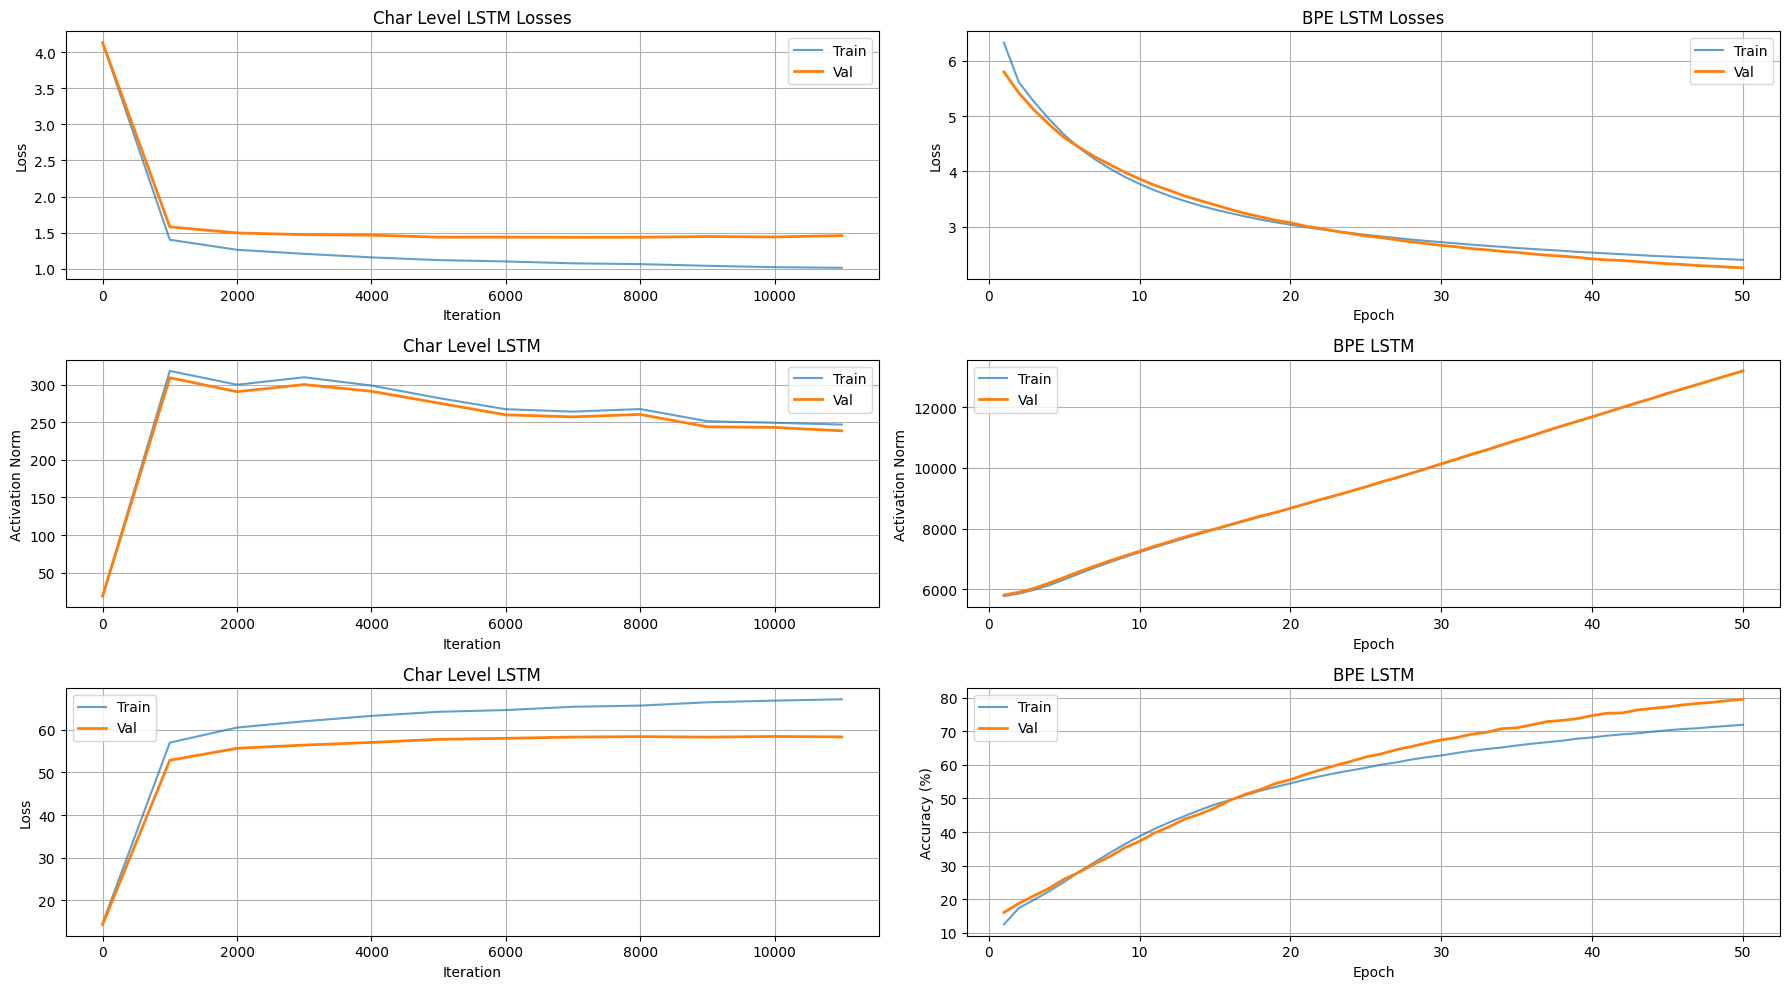

In [24]:
# Plot results
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

axes[0, 0].plot(history_char['eval_points'], history_char['avg_train_losses'], label='Train', alpha=0.7)
axes[0, 0].plot(history_char['eval_points'], history_char['val_losses'], label= 'Val', linewidth= 2)
axes[0, 0].grid(True)
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Char Level LSTM Losses')
axes[0,0].legend()

axes[0, 1].plot(history_bpe['epochs'], history_bpe['train_loss'], label='Train', alpha=0.7)
axes[0, 1].plot(history_bpe['epochs'], history_bpe['val_loss'], label= 'Val', linewidth= 2)
axes[0, 1].grid(True)
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].set_title('BPE LSTM Losses')
axes[0,1].legend()

axes[1, 0].plot(history_char['eval_points'], history_char['avg_train_act_norms'], label='Train', alpha=0.7)
axes[1, 0].plot(history_char['eval_points'], history_char['val_act_norms'], label= 'Val', linewidth= 2)
axes[1, 0].grid(True)
axes[1,0].set_xlabel('Iteration')
axes[1,0].set_ylabel('Activation Norm')
axes[1,0].set_title('Char Level LSTM')
axes[1,0].legend()

axes[1, 1].plot(history_bpe['epochs'], history_bpe['train_act_norm'], label='Train', alpha=0.7)
axes[1, 1].plot(history_bpe['epochs'], history_bpe['val_act_norm'], label= 'Val', linewidth= 2)
axes[1, 1].grid(True)
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Activation Norm')
axes[1,1].set_title('BPE LSTM')
axes[1,1].legend()

axes[2, 0].plot(history_char['eval_points'], history_char['train_accuracies'], label='Train', alpha=0.7)
axes[2, 0].plot(history_char['eval_points'], history_char['val_accuracies'], label= 'Val', linewidth= 2)
axes[2, 0].grid(True)
axes[2,0].set_xlabel('Iteration')
axes[2,0].set_ylabel('Loss')
axes[2,0].set_title('Char Level LSTM')
axes[2,0].legend()

axes[2, 1].plot(history_bpe['epochs'], history_bpe['train_acc'], label='Train', alpha=0.7)
axes[2, 1].plot(history_bpe['epochs'], history_bpe['val_acc'], label= 'Val', linewidth= 2)
axes[2, 1].grid(True)
axes[2,1].set_xlabel('Epoch')
axes[2,1].set_ylabel('Accuracy (%)')
axes[2,1].set_title('BPE LSTM')
axes[2,1].legend()

plt.tight_layout()
plt.show()



In [25]:
def generate_text(model, start_string, num_chars=1000, temperature=0.8, device='cpu'):

    model.eval()

    # Convert starting string to tensor
    chars = encode(start_string)
    input_tensor = torch.tensor(chars, dtype=torch.long).unsqueeze(0).to(device)

    # Initialize hidden state
    hidden = model.init_hidden(1, device)

    # If we have an LSTM, we need to handle the tuple
    if hasattr(model, 'cell_type') and model.cell_type == 'lstm':
        # For LSTM: hidden is (h, c)
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    else:
        # For RNN: just detach the hidden state
        hidden = hidden.detach()

    # Generate characters
    generated_chars = list(chars)

    with torch.no_grad():
        for i in range(num_chars):
            # Forward pass
            output, hidden = model(input_tensor, hidden)

            # Get last prediction
            logits = output[:, -1, :] / temperature
            probabilities = F.softmax(logits, dim=-1)

            # Sample from the distribution
            predicted_id = torch.multinomial(probabilities, 1).item()

            # Add to sequence and prepare next input
            generated_chars.append(predicted_id)
            input_tensor = torch.tensor([[predicted_id]], dtype=torch.long).to(device)

            # Update hidden state for next iteration
            if hasattr(model, 'cell_type') and model.cell_type == 'lstm':
                h, c = hidden
                h = h.detach()
                c = c.detach()
                hidden = (h, c)
            else:
                hidden = hidden.detach()

    # Decode the generated characters
    return decode(generated_chars)

In [26]:
def format_generated_text(text, max_line_length= 50, break_on_punctuation= True):
  # Clean up extra spaces or ?? (from <UNK>)
  text= re.sub(r'\s+', ' ', text.strip())
  text= text.replace('??', ' ')

  if break_on_punctuation:
    # Split on sentence-ending punctuation for natural breaks
    sentences= re.split(r'(?<=[\.\!\?])\s+', text)
    formatted= '\n'.join(sentences)
  else:
    # Simple word wrapping
    words= text.split()
    lines= []
    current_line= []
    current_length= 0

    for word in words:
      word_len= len(word) + 1
      if current_length + word_len > max_line_length and current_line:
        lines.append(' '.join(current_line))
        current_line= [word]
        current_length= word_len - 1 # No leading space
      else:
        current_line.append(word)
        current_length+= word_len
    if current_line:
      lines.append(' '.join(current_line))
    formatted= '\n'.join(lines)

  return formatted

In [29]:
# Generate text starting with a common Shakespearean phrase
generated_text = generate_text(
model_char,
start_string="First Citizen:",
num_chars=500,
temperature=0.8,
device=device
)

print(generated_text)
print("-" * 80)

First Citizen:
We will to what we buy the noble prince, how now
what shall we comfort?

MENENIUS:
Now, my lord, I'll send you hence in some hours.

LUCIO:
Sir, I have done such dearest love. Play thy true hand
and say he shall receive the market-place.

VALERIA:
Be you to be young Montague, and the more devise to you;
and when have I to stand in many hands that seems to
rightly seem upon him. I have proved thee for
the parties of the house of Lancaster?

LUCIO:
As doth be pride to wield us to my sister for hi
--------------------------------------------------------------------------------


In [30]:
# Test generation
sample_text = "First Citizen: "
generated = model_bpe.generate(
    prompt=sample_text,
    tokenizer=tokenizer,
    max_length=150,
    temperature=0.8,
    device=device
)

raw_output = generated[len(sample_text):].strip()
formatted_output = format_generated_text(raw_output, max_line_length=60, break_on_punctuation=True)

print(f"Generated text: \n{formatted_output}")

Generated text: 
Ay, he's a word for all.
First Citizen: And so did I; and the general must not come so.
SICINIUS: He's a very thing indeed: he is a lion o'er a child, and again To him will presently:--we shall pardon you, I will--give you all no way, sir.
VALERIA: My lord, you have a sure too, for your thanks; I' the gods tarry in them.
VALERIA: Let's could not, good night.
Be you himself, I have heard you say, a maid shall I be weary with you?
VIRGILIA: Good Camillo, by my leave.BURY: What, shall I not?
Prithee, be my count.
I'll to this
